<a href="https://colab.research.google.com/github/elambrop/Machine-Learned/blob/main/Various%20datasets/20210317_resnet34_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Classifing cars with transfer learning**


---

In this notebook we'll explore transfer learning on the [Stanford Cars dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html).

With transfer learning we can take advantage of pre-trained neural networks by training them to classify specific classes that may not be present in the original dataset.

In this notebook we will use ResNet34 network trained on the ImageNet dataset. SInce Keras does not have ResNet34 incorporated we are going to install it from [this](https://github.com/qubvel/classification_models) excellent GitHub repo.

In [ ]:
!pip install -q git+https://github.com/qubvel/classification_models

     |████████████████████████████████| 51kB 4.7MB/s 


We will also install the TensorFlow Add-ons package.

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 8.1MB/s 


Then we go ahead with the rest of the imports.

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import scipy.io as sp
import matplotlib.pyplot as plt

import os
import pathlib
import tarfile
import random
import pandas as pd
from PIL import Image

from classification_models.keras import Classifiers

In [ ]:
ResNet34, preprocess_input = Classifiers.get('resnet34')

In [ ]:
#download the training and testing datasets

!wget 'http://imagenet.stanford.edu/internal/car196/cars_train.tgz'

!wget 'https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz'

!wget 'http://imagenet.stanford.edu/internal/car196/cars_test.tgz'

fname1 = '/content/car_devkit.tgz'

tar = tarfile.open(fname1)
tar.extractall()
tar.close()

fname2 = '/content/cars_train.tgz'

tar = tarfile.open(fname2)
tar.extractall()
tar.close()

fname3 = '/content/cars_test.tgz'

tar = tarfile.open(fname3)
tar.extractall()
tar.close()

--2021-03-21 09:13:38--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  56.5MB/s    in 18s     

2021-03-21 09:13:56 (51.4 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]

--2021-03-21 09:13:56--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K  1.55MB/s    in 0.2s    

2021-03-21 09:13:57 (1.55 MB/s) - ‘car_devkit.tgz’ 

In [ ]:
# utility function for loading images

def load(image):
  im = tf.io.read_file(image)
  im = tf.image.decode_jpeg(im)
  return im

The training dataset contains 8144 pictures of 196 different car models. The classes are arranged alphabetically so we'll create a dictionary with key-value pairs that correspond to that structure, using the MAT files provided in the dataset homepage. 

In [ ]:
train_labels = sp.loadmat('/content/devkit/cars_train_annos.mat')

labels_index = sp.loadmat('/content/devkit/cars_meta.mat')

n_classes = len(labels_index['class_names'][0])

class_names = dict(zip(range(1,n_classes+1),[c[0] for c in labels_index['class_names'][0]]))

In [ ]:
train_data_dir = '/content/cars_train/'
test_data_dir = '/content/cars_test/'

The MAT files also contain bounding boxes for the cars in the images (the dataset can also be used for object detection tasks). We will create a Numpy array containing all that informaiton and use it to crop out the background in the images leaving only the car.

In [ ]:
train_fnames = [[row.flat[0] for row in line][-1] for line in train_labels['annotations'][0]]
train_classes = [[row.flat[0] for row in line][-2] for line in train_labels['annotations'][0]]
train_x1 = [[row.flat[0] for row in line][0] for line in train_labels['annotations'][0]]
train_y1 = [[row.flat[0] for row in line][1] for line in train_labels['annotations'][0]]
train_x2 = [[row.flat[0] for row in line][2] for line in train_labels['annotations'][0]]
train_y2 = [[row.flat[0] for row in line][3] for line in train_labels['annotations'][0]]

x1 = np.array(train_x1)
y1 = np.array(train_y1)
x2 = np.array(train_x2)
y2 = np.array(train_y2)
label = np.array(train_classes)
fname = np.array(train_fnames)

stack = np.stack((x1, y1, x2, y2, label, fname), axis=-1)

In [ ]:
#cropping and overwriting the image files

for l in stack:
  im = Image.open(train_data_dir+l[-1])
  im = im.crop((int(l[0]), int(l[1]), int(l[2]), int(l[3])))
  im.save(train_data_dir+l[-1])

In [ ]:
#here we append the number-encoded class names to the file names, which will be useful later

train_fpaths = []
for i in train_fnames:
  train_fpaths.append(train_data_dir+i)

for p, c in zip(train_fpaths, train_classes):
  os.rename(p, train_data_dir+str(c)+'_'+p.split('/')[-1])

To get an idea for the shape of the images contained in the dataset we will plot the height vs the width of the images.

In [ ]:
height = []
width = []
for i in os.listdir(train_data_dir):
  height.append(load(train_data_dir+i).shape[0])
  width.append(load(train_data_dir+i).shape[1])

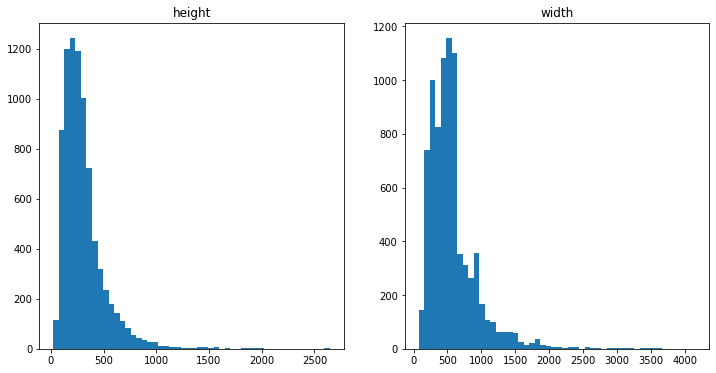

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('height')
plt.hist(height, bins=50)
plt.subplot(1,2,2)
plt.title('width')
plt.hist(width, bins=50)
plt.show()

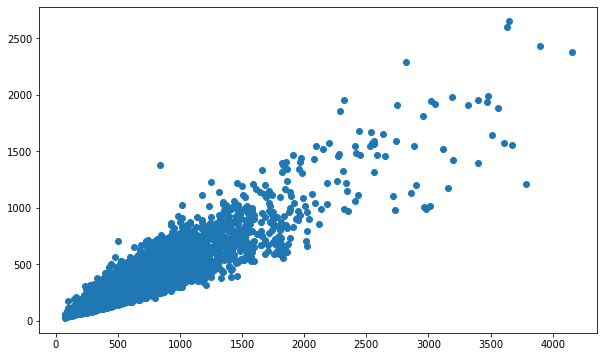

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(width, height)

The dataset contains images of a lot of different sizes but the majority is around 300 by 500. To make this more specific we perform simple linear regression on height vs width to find the mean aspect ratio.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()

lr.fit(np.array(height).reshape(-1,1), np.array(width).reshape(-1,1))

lr.coef_

array([[1.60262976]])

The mean aspect ratio is 1.6. However since ResNet34 was trained on 224 by 224 images we will resize the images to that size.

Now let's visualize some of the images.

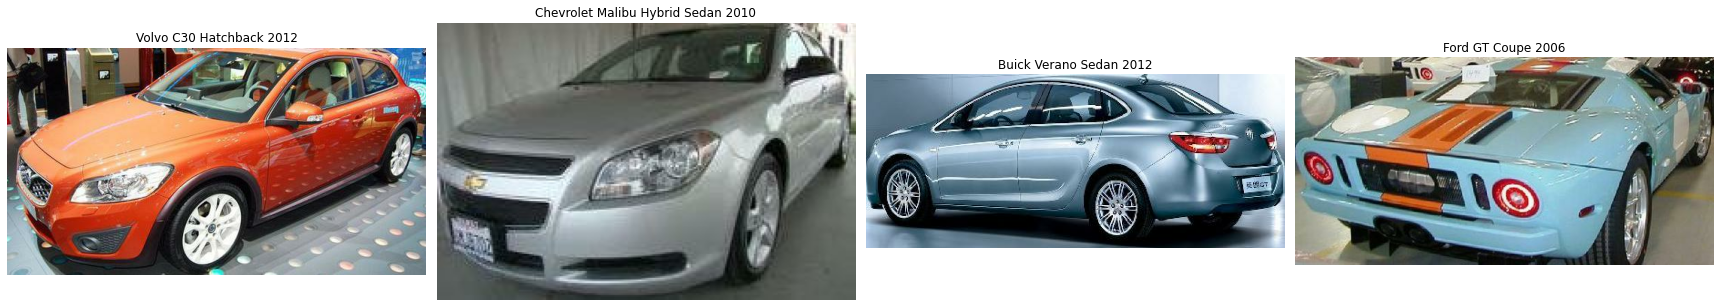

In [ ]:
plt.figure(figsize=(24,6))

for i in range(4):
  rand = random.randrange(0,100)
  img_path = train_data_dir + os.listdir(train_data_dir)[rand]
  img = load(img_path)

  plt.subplot(1,4,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(class_names[int(img_path.split('/')[-1].split('_')[-2])])

plt.tight_layout()
plt.show()

Next we define a function that creates the model. The base of the model is the ResNet34 network with the classifying layer removed and replaced with an output dense layer with 196 units corresponding to the 196 different classes. We also include a dropout layer to mitigate overfitting, since our dataset is small.

In [ ]:
def model():
  base_model = ResNet34(include_top=False, weights='imagenet', input_shape=(224,224,3))
  x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  x = tf.keras.layers.Dropout(0.3)(x)
  output = tf.keras.layers.Dense(196, activation='softmax')(x)

  return tf.keras.Model(inputs=[base_model.input], outputs=[output])

In [ ]:
full_model_a = model()
full_model_b = model()

 The typical workflow of transfer learning involves freezing the weights of the pre-trained layers and only updating the weights of the output layer. After a few epochs of training the pre-trained weights can be unfrozen and fine-tuned for some more accuracy. 
 However, due to a potential [issue](https://github.com/keras-team/keras/issues/9214) with Keras' Batch Normalization layer, I found that this procedure produced poor results. Instead, I kept the pre-trained layers trainable which produced decent results (although with significant overfitting as we will see).

 Next we define a preprocessing function that resizes the image, transforms it from RBG to BGR and also extracts the label from the file name.

In [ ]:
def load_preprocess(filename):
  im = tf.io.read_file(filename)
  im = tf.io.decode_jpeg(im, channels=3)
  im = tf.cast(im, tf.float32)
  im = tf.image.resize(im, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  im = preprocess_input(im)

  label = tf.strings.to_number(tf.strings.split(tf.strings.split(filename, sep='/')[-1], sep='_')[-2], tf.int32)
  label = tf.one_hot(label, depth=196, dtype=tf.float32)
  return im, label

We will also implement cut-out augmentation, a technique that crops out a small piece of the image, which makes the training process harder for the network, regularizing the weights in the process. The size of the cropped area is a hyperparameter that can hava an impact on the results, in this case I chose an area that is 1/9 of the original image.

In [ ]:
def augment_cutout(image, label):
  input_shape = tf.shape(image)
  img = tfa.image.random_cutout(image, (int(input_shape[1]/3), int(input_shape[2]/3)), constant_values = 0)
  return img, label

Now we load the dataset using tf.data.Dataset object.

In [ ]:
pathlib_data_dir = pathlib.Path(train_data_dir)

list_ds = tf.data.Dataset.list_files(str(pathlib_data_dir/'*'), shuffle=False)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

ds = list_ds.map(load_preprocess, num_parallel_calls=AUTO)

Let's visualize the effect of cut-out on the images.

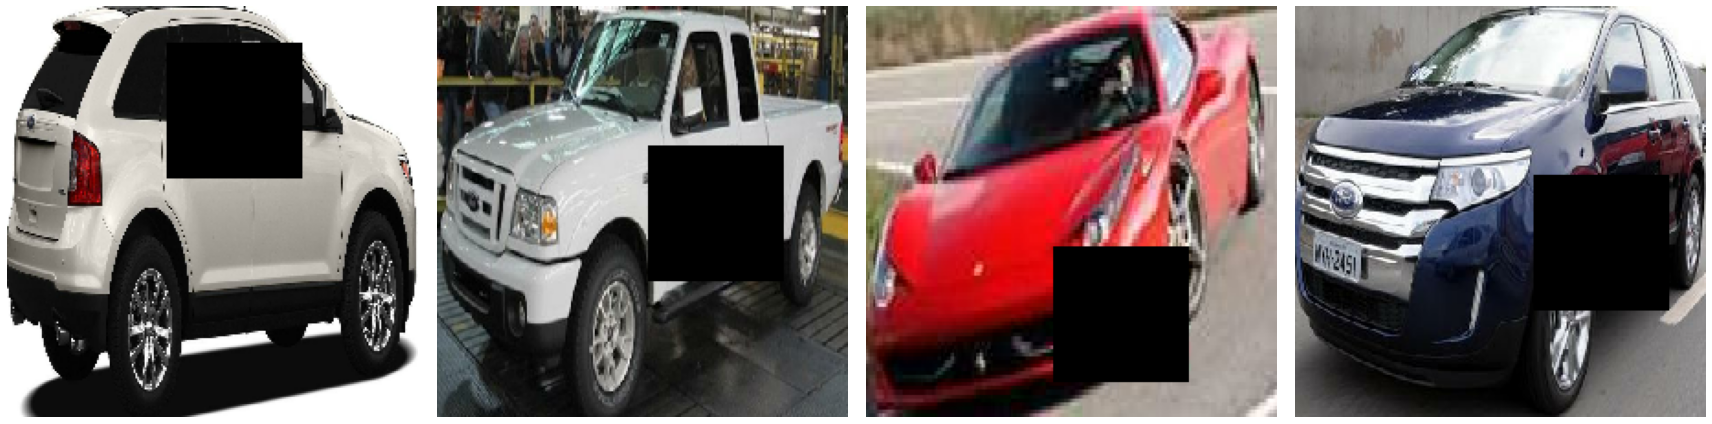

In [ ]:
plt.figure(figsize=(24,6))
for i, (img,label) in enumerate(ds.shuffle(1000).take(4).batch(1).map(augment_cutout)):
  plt.subplot(1,4,i+1)
  plt.imshow(tf.cast(img[0], tf.uint8))
  plt.axis('off')

plt.tight_layout()
plt.show()

We will split the dataset to training and validation subsets and also create an augmented copy of the original dataset and combine the two.

In [ ]:
SIZE = len(train_fnames)


full_ds = ds.shuffle(SIZE, reshuffle_each_iteration=False)
train_ds = full_ds.take(int(0.85*SIZE)).batch(64, drop_remainder=True)
aug_ds = train_ds.map(augment_cutout, num_parallel_calls=AUTO)

combined_ds = train_ds.concatenate(aug_ds).shuffle(2*int(0.85*SIZE)).prefetch(AUTO)

val_ds = full_ds.skip(int(0.85*SIZE)).batch(64, drop_remainder=True).prefetch(AUTO)

We will also use early stopping and a schedule that reduces the learning rate every 200 steps to try and reduce overfitting even more.

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=2,
                                         restore_best_weights=True)
schedule = tf.keras.optimizers.schedules.InverseTimeDecay(1e-3, 200, 0.5)

We will train two models, with and wthout cut-out at a fixed learning rate. Afterwards we will train two more with differential learning rates.

In [ ]:
full_model_a.compile(optimizer=tf.keras.optimizers.Adam(schedule), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

a_his = full_model_a.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[early], verbose=0, shuffle=False)

In [ ]:
full_model_b.compile(optimizer=tf.keras.optimizers.Adam(schedule), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

b_his = full_model_b.fit(combined_ds, validation_data=val_ds, epochs=15, callbacks=[early], verbose=0, shuffle=False)

In [ ]:
full_model_c = model()
full_model_d = model()

Differential learning rates are used to apply updates of different magnitude for different layers in the network. Typically with a pre-trained network, the layers closer to the input don't need as much changing as the ones closer to the output, so we split the network layers into groups and use smaller learning rates for lower layers.

In [ ]:
optimizers = [tf.keras.optimizers.Adam(1e-6),
              tf.keras.optimizers.Adam(1e-5),
              tf.keras.optimizers.Adam(1e-4),
              tf.keras.optimizers.Adam(1e-3),
              tf.keras.optimizers.Adam(1e-2)]

optimizers_and_layers = [(optimizers[0], full_model_c.layers[:36]),
                         (optimizers[1], full_model_c.layers[36:73]),
                         (optimizers[2], full_model_c.layers[73:128]),
                         (optimizers[3], full_model_c.layers[128:159]),
                         (optimizers[4], full_model_c.layers[159:])]

In [ ]:
full_model_c.compile(optimizer=tfa.optimizers.MultiOptimizer(optimizers_and_layers), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

c_his = full_model_c.fit(train_ds, validation_data=val_ds, epochs=15, verbose=0)

In [ ]:
full_model_d.compile(optimizer=tfa.optimizers.MultiOptimizer(optimizers_and_layers), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

d_his = full_model_d.fit(combined_ds, validation_data=val_ds, epochs=15, verbose=0)

Let's visualize our results.

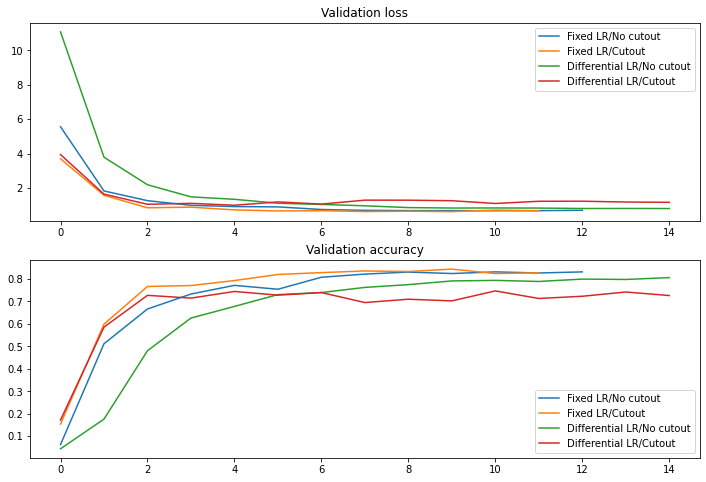

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,1)

fig.set_figheight(8)
fig.set_figwidth(12)

ax0.set_title('Validation loss')
ax0.plot(a_his.history['val_loss'], label='Fixed LR/No cutout')
ax0.plot(b_his.history['val_loss'], label='Fixed LR/Cutout')
ax0.plot(c_his.history['val_loss'], label='Differential LR/No cutout')
ax0.plot(d_his.history['val_loss'], label='Differential LR/Cutout')
ax0.legend()

ax1.set_title('Validation accuracy')
ax1.plot(a_his.history['val_accuracy'], label='Fixed LR/No cutout')
ax1.plot(b_his.history['val_accuracy'], label='Fixed LR/Cutout')
ax1.plot(c_his.history['val_accuracy'], label='Differential LR/No cutout')
ax1.plot(d_his.history['val_accuracy'], label='Differential LR/Cutout')
ax1.legend()

plt.show()

In [ ]:
print('Fixed learning rate - No cut-out:\n')
print(full_model_a.evaluate(val_ds))
print('\n')
print('Fixed learning rate - Cut-out:\n')
print(full_model_b.evaluate(val_ds))
print('\n')
print('Differential learning rate - No cut-out:\n')
print(full_model_c.evaluate(val_ds))
print('\n')
print('Differential learning rate - Cut-out:\n')
print(full_model_d.evaluate(val_ds))

Fixed learning rate - No cut-out:

19/19 [==============================] - 29s 112ms/step - loss: 0.6799 - accuracy: 0.8314
[0.6799201965332031, 0.8314144611358643]


Fixed learning rate - Cut-out:

19/19 [==============================] - 29s 113ms/step - loss: 0.6303 - accuracy: 0.8438
[0.6303181648254395, 0.84375]


Differential learning rate - No cut-out:

19/19 [==============================] - 28s 113ms/step - loss: 0.8083 - accuracy: 0.8059
[0.8082603812217712, 0.8059210777282715]


Differential learning rate - Cut-out:

19/19 [==============================] - 28s 112ms/step - loss: 1.1697 - accuracy: 0.7262
[1.1697407960891724, 0.7261512875556946]


The first thing to observe is that overfitting occured in all cases.

The model which was trained with a fixed learning rate and cut-out augmentation has produced the best results followed closely by the model with a fixed learning rate and no cut-out. The models trained with differential learning rates produce worse results. Somewhat surprisingly, between the two the one with augmentation performed worse, although in general more data give better results.

We can also try the models on some images from the test set (though we don't have the true labels to evaluate the models' performance).

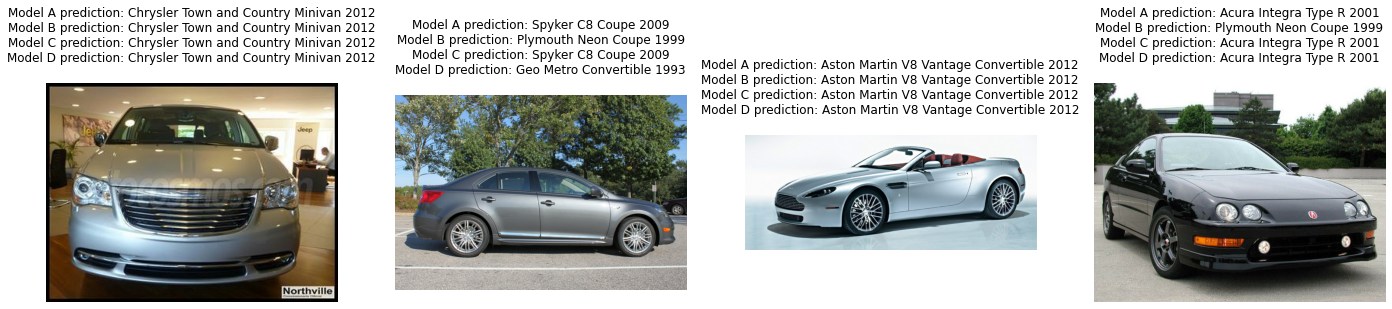

In [ ]:
plt.figure(figsize=(24,6))

for i in range(4):
  rand = random.randrange(0,100)
  img_path = test_data_dir + os.listdir(test_data_dir)[rand]
  img = load(img_path)
  a = np.argmax(full_model_a(tf.expand_dims(tf.image.resize(img, [224,224]), 0)))
  b = np.argmax(full_model_b(tf.expand_dims(tf.image.resize(img, [224,224]), 0)))
  c = np.argmax(full_model_c(tf.expand_dims(tf.image.resize(img, [224,224]), 0)))
  d = np.argmax(full_model_d(tf.expand_dims(tf.image.resize(img, [224,224]), 0)))
  
  plt.subplot(1,4,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title('Model A prediction: {}\nModel B prediction: {}\nModel C prediction: {}\nModel D prediction: {}\n'.format(class_names[a],
                                                                                                                      class_names[b],
                                                                                                                      class_names[c],
                                                                                                                      class_names[d]))

On the first and third picture the models unanimously predict the same model, and we can check on Google tha the prediction is correct. On the fourth picture three out of four models predict the correct class while the best of the three models makes a wrong prediction. On the second picture all models fail to give a correct prediction, possibly because the picure of the car is taken from the side.

## Conclusions
We demonstrated a first order approach to transfer learning with moderate success. The models exhibited overfitting but performing more data augmentation would probably help with that. Although differential learning rates did not show any benefit they could potentially be employed with different model architectures since ResNets seem to have issues in their Keras implementation.